# Ideen fürs Invertieren 

Problem: Für das berechnen der Strahlen braucht man die inverse Verzeichnungsfunktion (**Ent**zerrung $g(\overrightarrow{x})$). Als Eingabe haben wir (jedenfalls aus der LensFun-Datenbank) die **Ver**zerrung $f(\overrightarrow{x})$ als modellierte Funktion. Wenn man die Modelle, die die verwenden, z.B. das `Poly3` ($r_d = r_u (1 - k + k *r_u^2)$) mal von z.B. WolframAlpha invertieren lässt, kommt sowas heraus: 

![Eskalation](inversion_wolfram.jpg)

Andere Online-Tools bringen andere Ergebnisse, die aber ähnlich bescheuert aussehen. Direkt invertieren ist also eher Käse und wahrscheinlich auch nicht der Sinn der Aufgabe (Epiphanie hier), eher würde das Ganze so ablaufen:

- Als Eingabe bekommt die Kamera eine (irgendwie) _gemessene Verzeichnung_ (zum Beispiel in Form einer Funktion, die auf die gemessenen Pixelverschiebungen gefittet wurde, oder die gemessenen Verzeichnungen als Matrix für soundsoviele Punkte im Bild, oder...)
- In der `DistortionCamera` ist ein Modell (oder mehrere) zur Entzerrung implementiert. Das Modell wird dann auf die inverse (also quasi negierte) gemessenen Verzeichnung gefittet, die der User als Eingabe mitgegeben hat. Und daraus ergibt sich dann eine Funktion, die (hoffentlich) die gemessene Verzerrung ausreichend korrekt rückgängig macht. In Mathe: 
    - Eingabe als Modell $r_d = f(x,y) = r_u(1 - k + k r_u^2)$ mit $ r_u = \sqrt{(x -x_c)^2 + (y-y_c)^2}$
    - Ein Pixel $(x_1,y_1)$ wird dann auf $(x_2,y_2) = (x_1,y_1) + (r_d - r_u) \cdot \overrightarrow{e_r}$ geschoben
    - Entzerrt werden kann dann der Pixel $(x_2,y_2)$, indem $r_d - r_u$ abgezogen wird
    - Man könnte also die eingegebene Verzerrung für verschiedene Punkte $(x_1, y_1)$ abrastern und für die verschobenen Punkte $(x_2, y_2)$ die inverse Verschiebung (bzw. als Faktor) abspeichern und dann darauf das Entzerrungsmodell fitten
    
# Lensfun Invertierung

Die Lensfun Library kann Bilder entzerren, abgespeichert wird bei denen die gemessene **Ver**zerrung. Nirgendwo steht die Mathe, die bei denen dahinter steckt... :'(

Die notwendigen Python-Packages stehen in der `requirements.txt` Datei. Installieren mit ```pip install -r requirements.txt```

In [1]:
# Diese Zelle zuerst ausführen!!
import numpy as np
import matplotlib.pyplot as plt
from pynverse import inversefunc
import scipy

def poly3_lensfun(x, k):
    return x * (1 - k + k * np.power(x, 2))

def get_num_monomes_for_two_vars(n):
    return np.math.factorial(2 + n) / (2 * np.math.factorial(n))

def polynomial(x, y, n, a, b):
    assert(get_num_monomes_for_two_vars(n) == len(a))
    assert(get_num_monomes_for_two_vars(n) == len(b))
    if (n == 1):
        x_ret = a[0] * x + a[1] * y + a[2]
        y_ret = b[0] * y + b[1] * x + b[2]
    elif (n == 2):
        x_ret = a[0] * np.power(x,2) + a[1] * x * y + a[2] * np.power(y, 2) + a[3] * x + a[4] * y + a[5]
        y_ret = b[0] * np.power(y,2) + b[1] * y * x + b[2] * np.power(x, 2) + b[3] * y + b[4] * x + b[5]
    elif (n == 3):
        x_ret = a[0] * np.power(x,3) + a[1] * np.power(x,2) * y + a[2] * x * np.power(y,2) + a[3] * np.power(y,3) + a[4] * np.power(x,2) + a[5] * x * y + a[6] * np.power(y,2) + a[7] * x + a[8] * y + a[9]
        y_ret = b[0] * np.power(y,3) + b[1] * np.power(y,2) * x + b[2] * y * np.power(x,2) + b[3] * np.power(x,3) + b[4] * np.power(y,2) + b[5] * y * x + b[6] * np.power(x,2) + b[7] * y + b[8] * x + b[9]
    else:
        raise RuntimeError("Unsupported polynomial degree")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


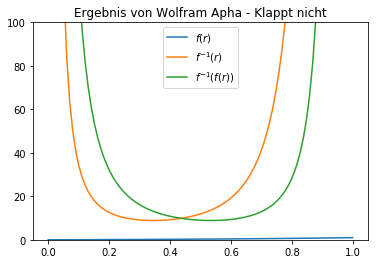

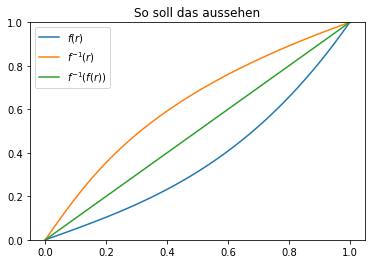

In [2]:
# Lösung von Wolfram Alpha ausprobieren

# feel the funk
func = poly3_lensfun
def inverse_func(x, k):
    # Nenner vom ersten und Zähler vom zweiten Bruch sind gleich:
    a = ( (729 * k**2 * x**4 - 108*(x - 1)**3 * x**3)**(1/2) -27 * k * x**2)**(3/2)
    fraction1 = (2**(3/2) * (x - 1)) / a
    fraction2 = a / (3 * (2)**(3/2) * x)
    return -fraction1 - fraction2

r = np.linspace(0, 1, 100)
k = 0.5
f = func(r, k)
f_inv = inverse_func(r, k)
should_be_linear = inverse_func(f,k)

l_f = '$f(r)$'
l_inv = r'$f^{-1}(r)$'
l_lin = r'$f^{-1}(f(r))$'

plt.plot(r, f, label=l_f)
plt.plot(r, f_inv, label=l_inv)
plt.plot(r, should_be_linear, label=l_lin)
plt.figure(1)
plt.plot()
plt.ylim(0,100)
plt.title('Ergebnis von Wolfram Apha - Klappt nicht')
plt.legend()
plt.show()

# invertieren mit python-library
inv_func = inversefunc(func, domain = [0,1], args = (k))
f_inv2 = inv_func(r)
should_be_linear = inv_func(f)
plt.figure(2)
plt.plot(r, f, label=l_f)
plt.plot(r, f_inv2, label=l_inv)
plt.plot(r, should_be_linear, label=l_lin)
plt.ylim(0,1)
plt.legend()
plt.title('So soll das aussehen')
plt.show()


## Funktion numerisch invertieren

### Poly3-Modell von Lensfun
Sei $v: (x_u, y_u) \to (x_d, y_d)$ die **Ver**zerrungsfunktion und $g: (x_d, y_d) \to (x_u, y_u)$ ihre Inverse. Seien $N$ Werte von $v$ bekannt $V = \{(x_1, y_1), (x_2, y_2),..., (x_N, y_N)\}$ mit $(x_i, y_i) = v(x_i', y_i')$ und $g = f(x, y, \overrightarrow{k})$, wobei $\overrightarrow{k} \in R^M$ der Vektor der Parameter von $g$ ist. Dann ist
$$ k \in argmin_{\overrightarrow{p} \in R^M} \{\sum_{i=1}^{N} (x - g(x_i, y_i, \overrightarrow{p}))^2\} $$

Beispiel:
Zur Entzerrung wird das `Poly3` Modell aus der Lensfun Datenbank angenommen:
$$g: r_u \to r_d, g(r_u) = r_u(1 - k + k \cdot r_u^2), V = \{r_{d,1}, r_{d,2},...,r_{d,N}\}$$
Die Verzerrung ist gemessen und dann in das selbe Modell mit einem Parameter $k_v$ verpackt worden, sodass die $N$ Werte in $V$ einfach berechnet werden können: $r_{d,i} = r_{u,i}(1 - k_v + k_v \cdot r_{u,i}^2), i \in \{1, 2, ..., N\}$, für eine (passend) ausgewählte Menge von Radii $\{r_{u,1}, r_{u,2},..., r_{u,N}\}$.
$$k \in argmin_{p \in R} \{ \sum_{i = 1}^{N} (r_u - r_i(1 - p + p \cdot r_i^2))^2\}$$

[0.30378309]


Text(0, 0.5, 'Mean squared Error')

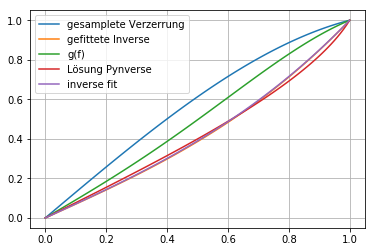

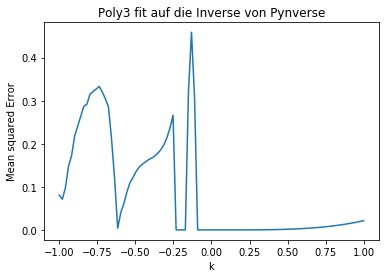

In [3]:
from functools import partial

k = -0.3
v = partial(poly3_lensfun, k=k)
sample_positions = np.linspace(0, 1, 100)
samples = v(sample_positions)
plt.figure(1)
plt.plot(sample_positions, samples, label="gesamplete Verzerrung")

### least-squares fit with scipy.optimize
# model function
def model(x, k):
    return poly3_lensfun(x, k)
# initial solution
k0 = 1/k     # what woould be a good guess?
def residual(k, target, x):
    return target - model(x, k)
target = sample_positions
k0=100
k_solved, flag = scipy.optimize.leastsq(residual, k0, args=(target, v(sample_positions)))
print(k_solved)

# plot model with fitted k
g = model(sample_positions, k_solved)
plt.plot(sample_positions, g, label="gefittete Inverse")

should_be_linear = model(samples, k_solved)
plt.plot(sample_positions, should_be_linear, label='g(f)')

pynverse_solution = inversefunc(v, domain=[0,1])
pynv_vals = pynverse_solution(sample_positions)
plt.plot(sample_positions, pynv_vals, label="Lösung Pynverse")

plt.grid()

# try to fit the model to the pynverse solution
target = pynv_vals
k0 = 1
k_solved, flag = scipy.optimize.leastsq(residual, k0, args=(target,sample_positions))
inverse_fit = model(sample_positions, k_solved)
plt.plot(sample_positions, inverse_fit, label='inverse fit')
plt.legend()


# plot mean squared error for different values of k
plt.figure(2)
mse_list = list()
k_values = np.linspace(-1, 1, 100)
for k in k_values:
    # compute inverse with pynverse
    model_func = lambda r: r * (1 - k + k * np.power(r, 2))
    inverse = inversefunc(model_func)(sample_positions)
    # fit the poly3 model to the inverse
    k0 = 0.1
    k_solved, flag = scipy.optimize.leastsq(residual, k0, args=(inverse, sample_positions))
    inverse_fit = model(sample_positions, k_solved)
    # compute mean squared error
    mse = np.sum(np.power(inverse_fit - inverse, 2)) / len(sample_positions)
    mse_list.append(mse)
    
# plot error over k
plt.plot(k_values, mse_list)
plt.title('Poly3 fit auf die Inverse von Pynverse')
plt.xlabel('k')
plt.ylabel('Mean squared Error')

## Polynomial Model

Das sowohl radiale und tangentiale Polynomial Model ergibt sich aus $P_n(x,y) = (k_1 x + k_2 y + k_3)^n$. Für ein Polynom vom Grad $n$ in $R^2$ sind damit $M = \frac{(2 + n)!}{2 \cdot k!}$ Koeffizienten nötig. Wir brauchen zwei Polynome ($x_2 = P_n(x,y)$ und $y_2 = P_n(x,y)$), mit jeweils eigenen Parametern, also doppelt so viele.

In [48]:
### polynomial model fitten

# Verzerrung aus Lenfsun modell samplen
k = 0.35
sample_positions = np.linspace(0, 1, 100)
samples = poly3_lensfun(sample_positions, k)

def residual(k, target, x):
    return x - polynomial()